In [65]:
import os
import random
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from glob import glob
from scipy.io import wavfile
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, Image
import sys

# Séparation de sources

La séparation de sources audio vise à extraire des signaux distincts à partir d’un enregistrement mélangé. Dans ce projet, nous nous concentrons sur la séparation de deux sources spécifiques dans un jeu de données contrôlé : un signal "propre", représentant un enregistrement vocal, et un signal "bruyant", constitué de sons de rue tels que des conversations, des pas et des véhicules.

## Exploration de données

### Taille des données

In [4]:
TRAIN_DIR = './data/source_separation/train'
TEST_DIR = './data/source_separation/test'

In [14]:
def count_dirs(directory):
    return sum(len(dirs) for _, dirs, _ in os.walk(directory))

In [15]:
nb_train = count_dirs(TRAIN_DIR)
nb_test = count_dirs(TEST_DIR)

print(f"Taille des données d'entraînement: {nb_train}")
print(f"Taille des données de test: {nb_test}")

Taille des données d'entraînement: 5000
Taille des données de test: 2000


### Visualisation des Données

Nous commençons par explorer un échantillon des signaux disponibles.

In [59]:
index = str(random.randint(0, nb_train-1)).zfill(4)
path = f'{TRAIN_DIR}/{index}'

for filename in os.listdir(path):
    if filename == "voice.wav":
        voice, sr = torchaudio.load(f"{path}/voice.wav")
        print("voice.wav")
        display(Audio(voice, rate=sr))
    elif filename == "noise.wav":
        noise, sr = torchaudio.load(f"{path}/noise.wav")
        print("noise.wav")
        display(Audio(noise, rate=sr))
    elif filename.startswith("mix_snr"):
        mix_audio, sr = torchaudio.load(f"{path}/{filename}")
        print("mix_snr_XX.wav")
        display(Audio(mix_audio, rate=sr))

mix_snr_XX.wav


noise.wav


voice.wav


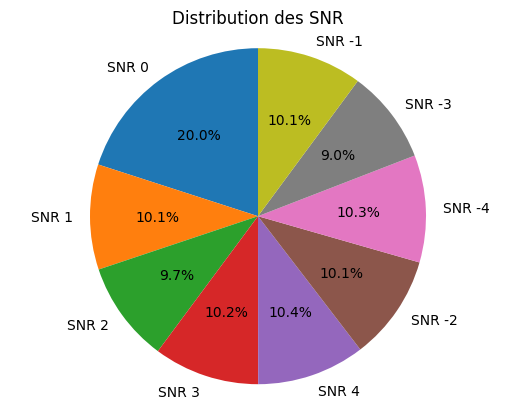

In [33]:
snr_values = [
    int(filename.split('_')[2].split('.')[0])
    for subdir in os.listdir(TRAIN_DIR)
    for filename in os.listdir(os.path.join(TRAIN_DIR, subdir))
    if filename.startswith("mix_snr_")
]

snr_counts = {snr: snr_values.count(snr) for snr in set(snr_values)}

plt.pie(snr_counts.values(), labels=[f"SNR {snr}" for snr in snr_counts], autopct='%1.1f%%', startangle=90)
plt.title('Distribution des SNR')
plt.axis('equal')
plt.show()

On observe que les valeurs de SNR varient entre -4 et 4, avec une concentration plus importante de données autour de SNR = 0. Pour les autres valeurs, la distribution est relativement équilibrée.

In [56]:
for snr in [4, 0, -4]:
    for subdir in os.listdir(TRAIN_DIR):
        subdir_path = os.path.join(TRAIN_DIR, subdir)
        
        if os.path.isdir(subdir_path):
            file_path = os.path.join(subdir_path, f"mix_snr_{snr}.wav")
            
            if os.path.exists(file_path):
                audio, sr = torchaudio.load(file_path)
                print(f'mix_snr_{snr}.wav')
                display(Audio(audio, rate=sr))
                break

mix_snr_4.wav


mix_snr_0.wav


mix_snr_-4.wav


On observe clairement que plus le SNR diminue, plus il devient difficile d'entendre la parole de manière claire.

## Baseline

Nous allons d'abord établir une baseline pour tester notre pipeline d'entraînement.

In [41]:
class AudioDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.files = self._load_files()

    def _load_files(self):
        files = []
        for subfolder in os.listdir(self.data_path):
            path = os.path.join(self.data_path, subfolder)
            files.append(
                (
                    list(glob(os.path.join(path, "mix_snr_*.wav")))[0],
                    os.path.join(path, 'voice.wav'),
                    os.path.join(path, 'noise.wav')
                )
            )
        return files
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mix_file, voice_file, noise_file = self.files[idx]
        mix_audio, _ = torchaudio.load(mix_file)
        voice_audio, _ = torchaudio.load(voice_file)
        noise_audio, _ = torchaudio.load(noise_file)
        mix_tensor = torch.FloatTensor(mix_audio / mix_audio.abs().max())
        voice_tensor = torch.FloatTensor(voice_audio / voice_audio.abs().max())
        noise_tensor = torch.FloatTensor(noise_audio / noise_audio.abs().max())
        return mix_tensor, voice_tensor, noise_tensor

def get_dataloader(data_path, batch_size=16, shuffle=True):
    dataset = AudioDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [42]:
def train(model, train_loader, valid_loader, criterion, optimizer, device="cpu", n_epochs=20, save_path="models/model.pth", log_dir="runs/experiment"):
    writer = SummaryWriter(log_dir=log_dir)
    model.to(device)

    for epoch in range(n_epochs):
        pbar = tqdm(train_loader, unit="batches")
        model.train()
        train_loss = 0.0
        for batch_mix, batch_signal, batch_noise in pbar:
            batch_mix, batch_signal, batch_noise = batch_mix.to(device), batch_signal.to(device), batch_noise.to(device)
            batch_signal_pred, batch_noise_pred = model(batch_mix)
            loss = _compute_loss(criterion, batch_signal_pred, batch_signal, batch_noise_pred, batch_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        writer.add_scalar("Loss/Train", train_loss, epoch)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_mix, batch_signal, batch_noise in valid_loader:
                batch_mix, batch_signal, batch_noise = batch_mix.to(device), batch_signal.to(device), batch_noise.to(device)
                batch_signal_pred, batch_noise_pred = model(batch_mix)
                loss = _compute_loss(criterion, batch_signal_pred, batch_signal, batch_noise_pred, batch_noise)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        writer.add_scalar("Loss/Validation", val_loss, epoch)

        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        torch.save(model.state_dict(), save_path)

def _compute_loss(criterion, signal_pred, signal, noise_pred, noise):
    return (criterion(signal_pred, signal) + criterion(noise_pred, noise)) / 2

In [46]:
class BaselineModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(BaselineModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(16, 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(8, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return torch.chunk(self.decoder(self.encoder(x)), 2, dim=1)

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
save_path = './models/baseline.pth'
log_dir = './runs/baseline'

train_loader = get_dataloader(TRAIN_DIR, batch_size=16, shuffle=True)
valid_loader = get_dataloader(TEST_DIR, batch_size=16, shuffle=True)

In [54]:
for batch in train_loader:
    print(f"Taille du batch: {batch[0].size()}")
    break

Taille du batch: torch.Size([16, 1, 80000])


Nous avons entraîné ce modèle pendant 50 epochs avec une fonction de perte MSE et l'optimiseur Adam avec un taux d'apprentissage de 0.001.

In [55]:
model = BaselineModel()
model.load_state_dict(torch.load('./models/baseline.pth', map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [62]:
mix_tensor = torch.FloatTensor(mix_audio / mix_audio.abs().max())

model.eval()
with torch.no_grad():
    signal_pred, noise_pred = model(mix_tensor.unsqueeze(0))

In [64]:
print("mix_snr_XX.wav")
display(Audio(mix_audio, rate=sr))

print("Voix prédite")
display(Audio(signal_pred.squeeze(0).numpy(), rate=sr))

mix_snr_XX.wav


Voix prédite


Nous observons la prédiction de la voix réalisée par notre modèle. Bien qu'il y ait du travail à faire pour affiner le filtrage, nous allons maintenant nous attaquer à Wave-U-Net.

## Wave-U-NET

Wave-U-Net est une architecture de réseau neuronal conçue spécifiquement pour la séparation de sources audio dans le domaine temporel. Contrairement à d'autres méthodes qui travaillent dans le domaine des spectrogrammes ou des coefficients de Fourier, Wave-U-Net opère directement sur les signaux audio bruts. Ce modèle, inspiré de l'architecture U-Net utilisée en traitement d'images, utilise des couches de convolution et de déconvolution pour séparer les sources tout en préservant les détails temporels.

L'approche de Wave-U-Net est particulièrement adaptée aux tâches de séparation de sources audio, telles que la séparation voix/bruit, car elle peut exploiter les informations locales du signal tout en apprenant des représentations efficaces des sources sous-jacentes.

In [71]:
Image(url="https://raw.githubusercontent.com/f90/Wave-U-Net/master/waveunet.png", width=400)